## Training VGG on CIFAR 10

In [20]:
#import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
# device

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on: {device}...")

Running on: cuda...


In [26]:
# Hyper parameter
batch_size=20
num_epochs=50
lr=1e-4
class_size=10
# percentage of training set to use as validation
valid_size = 0.2
# number of subprocesses to use for data loading
num_workers = 0


### Prepare dataset

In [41]:
transform_train = transforms.Compose([transforms.Resize((224,224)),                                     
                                     transforms.RandomHorizontalFlip(), 
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                          std=[0.229, 0.224, 0.225])])
transform_test = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(), 
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                         std=[0.229, 0.224, 0.225])])

#prep the train, validation and test dataset

train_data = torchvision.datasets.CIFAR10("data/", train=True, 
                                     download=True, 
                                     transform=transform_train) 

combined_test_data = torchvision.datasets.CIFAR10("data/", train=False, 
                                    download=True, 
                                    transform=transform_test) 

# Get targets from the test data for stratification
targets = combined_test_data.targets

# Stratified split for validation and test sets from the original test dataset
sss_test_valid = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)  # Split 50/50
valid_idx, test_idx = next(sss_test_valid.split(np.zeros(len(targets)), targets))

# Convert indices to actual Subset for validation and test datasets
valid_data = Subset(combined_test_data, valid_idx)
test_data = Subset(combined_test_data, test_idx)


#  train, val and test datasets to the dataloader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


images.shape: torch.Size([64, 3, 224, 224])


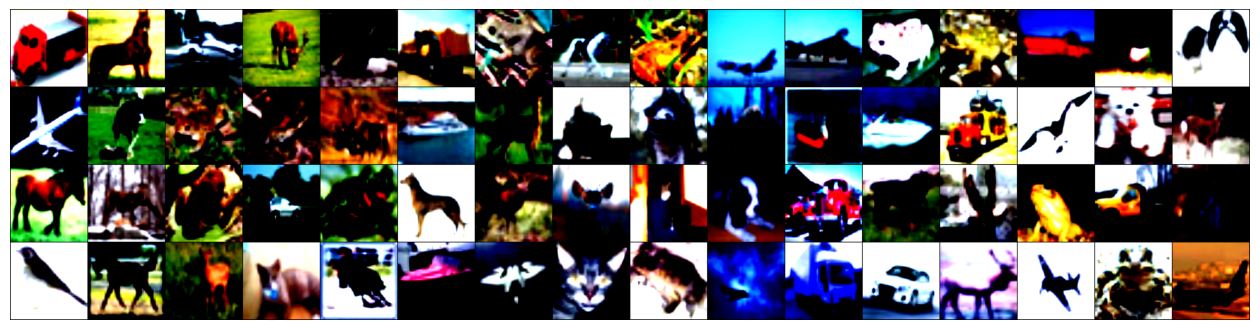

In [25]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [16]:
train_loader

### Model Definition

In [10]:
class VGG16_NET(nn.Module):
    def __init__(self):
        super(VGG16_NET, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv8 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv11 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv13 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc14 = nn.Linear(25088, 4096)
        self.fc15 = nn.Linear(4096, 4096)
        self.fc16 = nn.Linear(4096, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = self.maxpool(x)
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = self.maxpool(x)
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = F.relu(self.conv13(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc14(x))
        x = F.dropout(x, 0.5) #dropout was included to combat overfitting
        x = F.relu(self.fc15(x))
        x = F.dropout(x, 0.5)
        x = self.fc16(x)
        return x

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
VGG16 = VGG16_NET() 
VGG16 = VGG16.to(device=device) 
load_model = True
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(VGG16.parameters(), lr= lr) 

In [42]:
# number of epochs to train the model
n_epochs = 1

valid_loss_min = np.inf # track change in validation loss

for epoch in range(1, n_epochs+1):
  # keep track of training and validation loss
  train_loss = 0.0
  valid_loss = 0.0
    
  ###################
  # train the model #
  ###################
  VGG16.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    # move tensors to GPU if CUDA is available
    data, target = data.to(device), target.to(device)
    # clear the gradients of all optimized variables
    optimizer.zero_grad()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = VGG16(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()
    # perform a single optimization step (parameter update)
    optimizer.step()
    # update training loss
    train_loss += loss.item()*data.size(0)
        
  ######################    
  # validate the model #
  ######################
  VGG16.eval()
  for batch_idx, (data, target) in enumerate(valid_loader):
    # move tensors to GPU if CUDA is available
    
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = VGG16(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update average validation loss 
    valid_loss += loss.item()*data.size(0)
    
  # calculate average losses
  train_loss = train_loss/len(train_loader.sampler)
  valid_loss = valid_loss/len(valid_loader.sampler)
        
  # print training/validation statistics 
  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
      epoch, train_loss, valid_loss))
    
  # save model if validation loss has decreased
  if valid_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
    valid_loss_min,
    valid_loss))
    torch.save(VGG16.state_dict(), 'VGG16.pt')
    valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.132892 	Validation Loss: 0.955173
Validation loss decreased (inf --> 0.955173).  Saving model ...


In [43]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

VGG16.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
  # move tensors to GPU if CUDA is available
  
  data, target = data.to(device), target.to(device)
  # forward pass: compute predicted outputs by passing inputs to the model
  output = VGG16(data)
  # calculate the batch loss
  loss = criterion(output, target)
  # update test loss 
  test_loss += loss.item()*data.size(0)
  # convert output probabilities to predicted class
  _, pred = torch.max(output, 1)    
  # compare predictions to true label
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
  # calculate test accuracy for each object class
  for i in range(batch_size):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
  if class_total[i] > 0:
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
        classes[i], 100 * class_correct[i] / class_total[i],
        np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
    print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.951274

Test Accuracy of airplane: 73% (369/500)
Test Accuracy of automobile: 81% (405/500)
Test Accuracy of  bird: 45% (228/500)
Test Accuracy of   cat: 60% (304/500)
Test Accuracy of  deer: 58% (290/500)
Test Accuracy of   dog: 62% (312/500)
Test Accuracy of  frog: 72% (360/500)
Test Accuracy of horse: 70% (352/500)
Test Accuracy of  ship: 71% (357/500)
Test Accuracy of truck: 73% (365/500)

Test Accuracy (Overall): 66% (3342/5000)
